In [1]:
import sys
import json
import pickle
import pyspark
from functools import reduce
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import udf, mean, lit, stddev, col, expr, when
from pyspark.sql.types import DoubleType, ArrayType, ShortType, LongType, IntegerType
import pandas as pd
from collections import OrderedDict
from datetime import date
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from pyspark.storagelevel import StorageLevel

In [2]:
STORAGE_ACCOUNT_SUFFIX = 'core.windows.net'
STORAGE_ACCOUNT_NAME = os.environ['STORAGE_ACCOUNT_NAME']
TELEMETRY_CONTAINER_NAME = 'telemetry'

wasbUrlInput = "wasb://{0}@{1}.blob.{2}/*/*/*/*/*/*/*".format(
            TELEMETRY_CONTAINER_NAME,
            STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX)

sc = SparkContext.getOrCreate()

hc = sc._jsc.hadoopConfiguration()
hc.set("avro.mapred.ignore.inputs.without.extension", "false")
# hc.set("fs.azure.account.key.{}.blob.core.windows.net".format(STORAGE_ACCOUNT_NAME), STORAGE_ACCOUNT_KEY)

sql = SQLContext.getOrCreate(sc)

df = sql.read.format("com.databricks.spark.avro").load(wasbUrlInput)

df.printSchema()

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- Properties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- SystemProperties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- Body: binary (nullable = true)



In [3]:
print('Message count: {0}'.format(df.count()))

Message count: 19360


In [4]:
sample_rate = 8000

def extract_double(c):
    return udf(lambda x: float(pickle.loads(x)[c]), DoubleType())

def extract_array(c):
    return udf(lambda x: pickle.loads(x)[c], ArrayType(ShortType()))

def extract_amplitude_spectrum(c):
    def m(x):
        ampl = np.abs(np.fft.fft(pickle.loads(x)[c])) / sample_rate
        return ampl[:sample_rate // 2 + 1].tolist()
                      
    return udf(m, ArrayType(DoubleType()))

def extract_dominant_frequencies(index):
    def m(ff):
        freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
        return [float(f[index]) for f in sorted(list(zip(freq, ff)), key = lambda x: x[1], reverse = True)]
    
    return udf(m, ArrayType(DoubleType()))


dfa = (df
       .withColumn('machineID', df.SystemProperties['connectionDeviceId'])
       .withColumn("speed", extract_double("speed")(df.Body))
       .withColumn("temperature", extract_double("temperature")(df.Body))
       .withColumn("pressure", extract_double("pressure")(df.Body))
       .withColumn("vibration", extract_array("vibration")(df.Body))
       .withColumn("fft", extract_amplitude_spectrum("vibration")(df.Body))
       .drop('Properties', 'SystemProperties', 'Body'))

dfa = (dfa
       .withColumn("dominant_frequencies", extract_dominant_frequencies(0)(dfa.fft))
       .withColumn("dominant_frequencies_amplitudes", extract_dominant_frequencies(1)(dfa.fft)))

In [5]:
df.unpersist()
dfa.printSchema()
samples = dfa.limit(5).toPandas()
dfa.registerTempTable('dfa')

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- machineID: string (nullable = true)
 |-- speed: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- vibration: array (nullable = true)
 |    |-- element: short (containsNull = true)
 |-- fft: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dominant_frequencies: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dominant_frequencies_amplitudes: array (nullable = true)
 |    |-- element: double (containsNull = true)



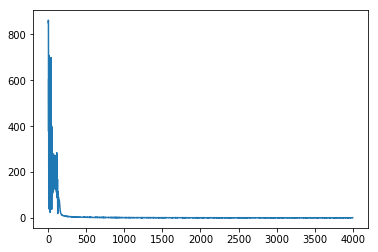

In [6]:
#dfa.limit(5).toPandas()
plt.plot(dfa.first().fft)
plt.show()

In [7]:
k = dfa.where(dfa.machineID == 'pm1-353').orderBy('EnqueuedTimeUtc').select('vibration').take(100)
k = np.concatenate(np.array([x.vibration for x in k]))

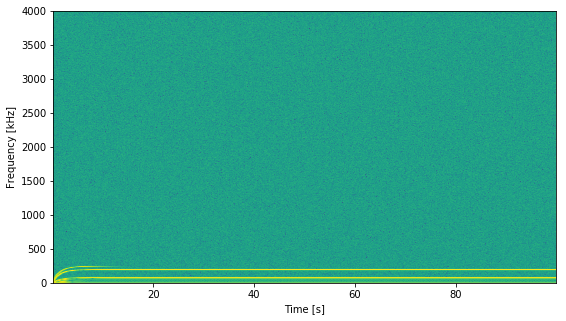

In [8]:
freqs, times, Sx = signal.spectrogram(k, fs=8000, window='hanning',
                                      nperseg=4096, noverlap=4096 - 100,
                                      detrend=False, scaling='spectrum')
f, ax = plt.subplots(figsize=(9, 5))
ax.pcolormesh(times, freqs, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]')
plt.show()

In [9]:
freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
max_freq = sorted(list(zip(freq, dfa.sample(False, 0.1, seed=0).first().fft)), key = lambda x: x[1], reverse = True)[10 : ]
pdf = pd.DataFrame.from_records(max_freq)
pdf.head()

,0,1
0,21.0,318.568404
1,80.0,314.032311
2,245.0,311.808111
3,42.0,306.860829
4,103.0,289.674834


In [10]:
frequency_features = 3
dfa = reduce(lambda _df, i: _df.withColumn('f{0}'.format(i), _df.dominant_frequencies[i]), range(frequency_features), dfa)
dfa = reduce(lambda _df, i: _df.withColumn('a{0}'.format(i), _df.dominant_frequencies_amplitudes[i]), range(frequency_features), dfa)
dfa = dfa.drop('vibration', 'fft', 'dominant_frequencies', 'dominant_frequencies_amplitudes')
dfa.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[EnqueuedTimeUtc: string, machineID: string, speed: double, temperature: double, pressure: double, f0: double, f1: double, f2: double, a0: double, a1: double, a2: double]

In [11]:
dependent_features = [c for c in dfa.columns if c not in ['machineID', 'EnqueuedTimeUtc', 'speed']]
dfa = reduce(lambda _df, f: _df.withColumn('{0}_n'.format(f), col(f) / col('speed')), dependent_features, dfa)

In [12]:
wasbUrlOutput = "wasb://{0}@{1}.blob.{2}/features.parquet".format(
            'intermediate',
            STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX)

dfa.write.parquet(wasbUrlOutput, mode="overwrite")

dfa.limit(5).toPandas().head()

,EnqueuedTimeUtc,machineID,speed,temperature,pressure,f0,f1,f2,a0,a1,a2,temperature_n,pressure_n,f0_n,f1_n,f2_n,a0_n,a1_n,a2_n
0,2018-03-13T23:25:22.0060000Z,pm1-354,610.0,20.026253,1106.970997,1.0,0.0,2.0,861.902575,851.777000,836.474269,0.032830,1.814707,0.001639,0.000000,0.003279,1.412955,1.396356,1.371269
1,2018-03-13T23:25:22.1620000Z,pm1-355,665.0,20.031709,1075.281674,1.0,0.0,2.0,852.363487,848.027625,818.216892,0.030123,1.616965,0.001504,0.000000,0.003008,1.281750,1.275230,1.230401
2,2018-03-13T23:25:22.4120000Z,pm1-354,915.0,20.086678,1339.186596,57.0,59.0,23.0,624.896003,565.998780,485.836701,0.021953,1.463592,0.062295,0.064481,0.025137,0.682946,0.618578,0.530969
3,2018-03-13T23:25:22.5370000Z,pm1-355,997.5,20.102885,1355.603202,64.0,59.0,57.0,564.584214,530.892912,485.906448,0.020153,1.359001,0.064160,0.059148,0.057143,0.565999,0.532223,0.487124
4,2018-03-13T23:25:23.4750000Z,pm1-354,1067.5,20.167356,1536.193346,32.0,34.0,33.0,709.592489,708.426575,601.554421,0.018892,1.439057,0.029977,0.031850,0.030913,0.664724,0.663631,0.563517
